In [254]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,auc,classification_report,confusion_matrix,roc_curve,roc_auc_score

from sklearn.compose import ColumnTransformer


from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import LabelEncoder


import joblib

In [189]:
df = pd.read_csv(r"../data/raw/data.csv")

In [190]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [191]:
cat_columns = ['Self_Employed',
 'Dependents',
 'Gender',
 'Married',
 'Education',
 'Property_Area',
 'Credit_History']

num_columns = ['LoanAmount','ApplicantIncome','TotalApplicantIncome']

In [192]:
class PipeCustomOrdinalEncoder(BaseEstimator,TransformerMixin):
    '''
    Converts categories into numbers for KNNImputing
    '''
    
    def __init__(self):
        self.ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=1001)
#         self.feature = feature_name
    
    def fit(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        self.ord_encoder = self.ord_encoder.fit(not_na_np)
        return self
    
    def transform(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        transformed_data = self.ord_encoder.transform(not_na_np)
        not_na_encode = pd.Series(transformed_data.flatten(),index = not_na_rows.index.values)
        return pd.DataFrame(pd.concat([not_na_encode,X[X.isna()]]).sort_index())
    
    def inverse_transform(self,X,y=None):
        col = X.to_numpy().reshape(-1,1)
        return self.ord_encoder.inverse_transform(col)

In [193]:
class CustomKNNImputer():
    
    def __init__(self,n_neighbors):
        self.imputer = KNNImputer(n_neighbors=n_neighbors)
    
    def fit(self,X,y=None):
        self.imputer = self.imputer.fit(X)
        return self.imputer 
    
    def transform(self,X,y=None):
        return pd.DataFrame(self.imputer.transform(X),columns=X.columns)
    
    def fit_transform(self,X,y=None):
        self.imputer = self.imputer.fit(X)
        return self.transform(X,y)
    

In [194]:
def return_df(x,cols=None):
    return pd.DataFrame(x,columns=cols)

In [215]:
def transform_dataset(data):
    data.loc[:,"LoanAmount"] = np.log(data.LoanAmount)
    data.loc[:,"TotalApplicantIncome"] = np.log(data.ApplicantIncome+data.CoapplicantIncome)
    data.loc[:,"ApplicantIncome"] = np.log(data.ApplicantIncome)
    data = data.drop(columns=['CoapplicantIncome','Loan_ID','Loan_Amount_Term'])
    return data

In [216]:
transformations = FunctionTransformer(transform_dataset)


cat_preprocess = ColumnTransformer(transformers=[
    ('employed',PipeCustomOrdinalEncoder(),'Self_Employed'),
    ('dependents',PipeCustomOrdinalEncoder(),'Dependents'),
#     ('loan_amount',CustomOrdinalEncoder(),'Loan_Amount_Term'),
    ('married',PipeCustomOrdinalEncoder(),'Married'),
    ('gender',PipeCustomOrdinalEncoder(),'Gender'),
    ('education',PipeCustomOrdinalEncoder(),'Education'),
    ('property',PipeCustomOrdinalEncoder(),'Property_Area'),
    ('credit-history',PipeCustomOrdinalEncoder(),'Credit_History')
                                                ])

categories = Pipeline(steps=[
    ('cat',cat_preprocess),
    ('cat_names',FunctionTransformer(return_df,kw_args={"cols":cat_columns}))
])

num_preprocess = ColumnTransformer(
transformers=[
    ('num_scaling',MinMaxScaler(),num_columns)
])

numerical = Pipeline(steps=[
    ('num',num_preprocess),
    ('num_names',FunctionTransformer(return_df,kw_args={"cols":num_columns}))
])

impute_preprocess = Pipeline(steps=[
    ('feature_union',FeatureUnion(transformer_list=[
        ('cat_pipe',categories),
        ('num_pipe',numerical)
    ])),
    ('test',FunctionTransformer(return_df,kw_args={"cols":cat_columns+num_columns})),
    ('imputer',CustomKNNImputer(n_neighbors=1,))
])

one_hot_encoding_preprocess = FeatureUnion(transformer_list=[
        ('cat_features',ColumnTransformer(
            transformers=[('categorical',OneHotEncoder(),cat_columns),]
        )),
        ('num_features',ColumnTransformer(
            transformers=[('numeric','passthrough',num_columns),]
        ))
    ])

preprocessing = Pipeline(steps=[
    ('impute',impute_preprocess),
    ('one_hot_encoded',one_hot_encoding_preprocess)
])

pipe = Pipeline(steps=[
    ('transformations',transformations),
    ('preprocess',preprocessing),
    ('model',LogisticRegression(random_state=123,fit_intercept=True,max_iter=1000))
],verbose=True)



In [217]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Loan_Status']),
                                                 df['Loan_Status'],stratify=df['Loan_Status'],random_state=60,train_size=0.6)

In [218]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [220]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [221]:
params = {}

In [222]:
model = GridSearchCV(pipe,param_grid=params)
model = model.fit(X_train,y_train)

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s
[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[Pipeline] ... (step 1 of 3) Processing transformations, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing preprocess, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s


In [223]:
f1_score(y_train,model.predict(X_train))

0.861646234676007

In [224]:
f1_score(y_test,model.predict(X_test))

0.8693333333333333

In [247]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.30      0.45        77
           1       0.76      0.99      0.86       169

    accuracy                           0.77       246
   macro avg       0.84      0.64      0.65       246
weighted avg       0.81      0.77      0.73       246



In [249]:
print(confusion_matrix(y_test,model.predict(X_test)))

[[ 23  54]
 [  2 167]]


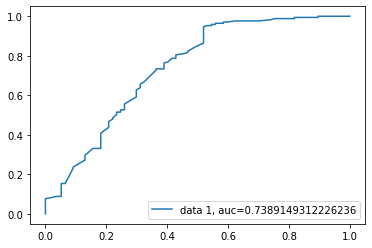

In [266]:
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [260]:
from sklearn import metrics
preds = model.predict_proba(X_test)
tpr, tpr, thresholds = roc_curve(y_test,preds[:,1])
print (thresholds)

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(preds[:,1]>thres,1,0)
    # Apply desired utility function to y_preds, for example accuracy.
    accuracy_ls.append(f1_score(y_test, y_pred))

[1.94664444 0.94664444 0.92575128 0.92203559 0.91846689 0.9030831
 0.90292366 0.90221544 0.90213361 0.89635603 0.8872382  0.8864825
 0.87853774 0.87806116 0.87684346 0.87126467 0.86895535 0.8673197
 0.85221692 0.85176746 0.84653502 0.8391011  0.83345625 0.8309759
 0.82687704 0.8204226  0.80876209 0.80324335 0.79713405 0.79584559
 0.79457665 0.78287307 0.7819285  0.7816005  0.7789039  0.76873907
 0.76837915 0.7646719  0.76324399 0.76217336 0.75521779 0.75501657
 0.75045395 0.73857386 0.73837129 0.73775059 0.7360423  0.72569039
 0.7179991  0.71717776 0.70938003 0.70565788 0.68893862 0.6821778
 0.67380206 0.63141424 0.59522698 0.59124583 0.58476925 0.58019689
 0.55100502 0.48332477 0.46466384 0.4614696  0.34871209 0.2720232
 0.27038225 0.22263372 0.21672204 0.20099761 0.17593574 0.14554205
 0.13547439 0.13212545 0.12943077 0.12476214 0.10392081 0.04837853]


In [225]:
joblib.dump(model,r"../models/1_base_model.sav")

['../models/1_base_model.sav']

In [268]:
predict= df.sample(n=1,random_state=330)

In [269]:
predict

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
283,LP001917,Female,No,0,Graduate,No,1811,1666.0,54.0,360.0,1.0,Urban,Y


In [270]:
model.predict(predict.drop(columns=["Loan_Status"]))

array([1])

In [272]:
predict.to_json()

'{"Loan_ID":{"283":"LP001917"},"Gender":{"283":"Female"},"Married":{"283":"No"},"Dependents":{"283":"0"},"Education":{"283":"Graduate"},"Self_Employed":{"283":"No"},"ApplicantIncome":{"283":1811},"CoapplicantIncome":{"283":1666.0},"LoanAmount":{"283":54.0},"Loan_Amount_Term":{"283":360.0},"Credit_History":{"283":1.0},"Property_Area":{"283":"Urban"},"Loan_Status":{"283":"Y"}}'